In [1]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import sys
sys.path.insert(1, '../src/tregseq')
import wgregseq
import simulate

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Load sequences of binding sites

In [10]:
# Operator sequences
O1 = 'AATTGTGAGCGGATAACAATT'
O2 = 'AAATGTGAGCGAGTAACAACC'
O3 = 'GGCAGTGAGCGCAACGCAATT'

# Promoter
lacWT = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In this notebook, we will simulate a synthetic dataset for a gene with the simple repression regulatory architecture. We choose the lacZYA promoter, which contains the LacI O1 binding site. The energy matrices for LacI and RNAP have been previously determined in 

https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

## Load promoter sequence

First we load the sequence of the lacZYA promoter assuming that the length of the promoter is 160bp.

In [6]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [7]:
## Find the transcription start site

df = pd.read_csv('../data/ecoli_gene_list.csv')
lacO1_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
lacO1_TSS

366343

In [8]:
lacO1 = simulate.get_regulatory_region(genome, lacO1_TSS, reverse=True)
lacO1

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [13]:
lacO1.find(lacWT)

74

## Load energy matrices

In [6]:
# Import matrices
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')
O2_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO2.npy')
O3_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO3.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
O2_1027_fixed = np.zeros(np.shape(O2_1027_raw))
O3_1027_fixed = np.zeros(np.shape(O3_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = ss.fix_wt(O1_1027_raw[i], 'AATTGTGAGCGGATAACAATT')
    O2_1027_fixed[i] = ss.fix_wt(O2_1027_raw[i], 'AAATGTGAGCGAGTAACAACC')
    O3_1027_fixed[i] = ss.fix_wt(O3_1027_raw[i], 'GGCAGTGAGCGCAACGCAATT')

O1_emat = np.mean(O1_1027_fixed, axis=0)
O2_emat = np.mean(O2_1027_fixed, axis=0)
O3_emat = np.mean(O3_1027_fixed, axis=0)

In [7]:
# Set up dictionaries that can be used to make a dataframe for all predictions and measurements
energy_dict = {'O1' : -15.3, 'O2' : -13.9, 'O3' : -9.7}

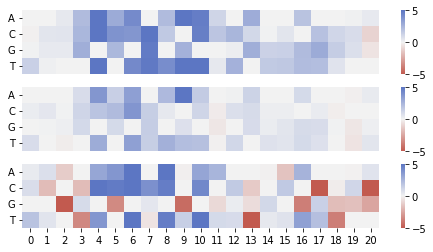

In [8]:
div_colors = sns.diverging_palette(16, 258, s=56, l=51, n=15, sep=2, center='light', as_cmap=True)
fig_mats = [O1_emat, O2_emat, O3_emat]

fig, axes = plt.subplots(nrows=3, figsize=(8, 4))
for i, ax in enumerate(axes):
    sns.heatmap(fig_mats[i].T, cmap=div_colors, ax=ax, vmin=-5, vmax=5)
    ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360)
    if i != 2:
        ax.set_xticks([])

In [9]:
rnap_emat = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')

# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

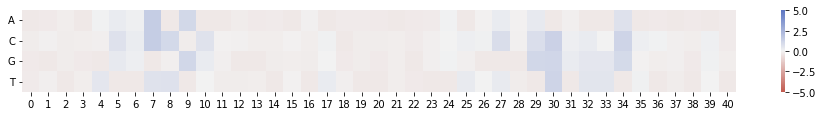

In [10]:
fig, ax = plt.subplots(figsize=(16, 1.5))
sns.heatmap(rnap_emat.T, cmap=div_colors, ax=ax, vmin=-5, vmax=5)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360)
plt.show()

## Calculate transcription rate

In [11]:
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    n_NS = len(record.seq)

In [12]:
names = ['O1', 'O2', 'O3']
seqs = [O1, O2, O3]
emats = [O1_emat, O2_emat, O3_emat]

In [13]:
n_repressors = np.logspace(0, 4, num = 100)
foldchange = []
for i in range(3):
    foldchange.append([])
    for n_r in n_repressors:
        fc = ss.get_foldchange(seqs[i], emats[i], n_r, n_NS, e_wt=energy_dict[names[i]])
        foldchange[i].append(fc)

In [14]:
colors = sns.color_palette("hls", 3)

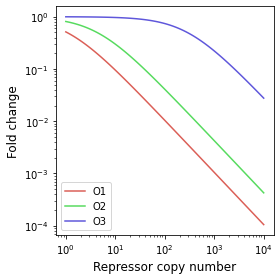

In [15]:
# Figure 1 theory paper Fig.11a

fig, ax = plt.subplots(figsize=(4,4))
for i in range(3):
    ax.plot(n_repressors, foldchange[i], color=colors[i])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Repressor copy number', fontsize=12)
ax.set_ylabel('Fold change', fontsize=12)
ax.legend(names)
plt.tight_layout()
#plt.savefig('./plots/fig11a.png', dpi=300)
plt.show()

## Generate mutated sequences

In [16]:
lacO1_mutants = np.unique(wgregseq.mutations_rand(lacO1, rate=0.1, num_mutants=100000, number_fixed=True))
#lacO2_mutants = np.unique(wgregseq.mutations_rand(lacUV5_O2, rate=0.1, num_mutants=100000, number_fixed=True))
#lacO3_mutants = np.unique(wgregseq.mutations_rand(lacUV5_O3, rate=0.1, num_mutants=100000, number_fixed=True))

In [17]:
n_p = 1500
n_r = 62

In [18]:
lac_start, lac_end = ss.find_binding_site(lacO1, lacWT)
O1_start, O1_end = ss.find_binding_site(lacO1, O1)

In [19]:
l_tr = []
for mut in lacO1_mutants:
    rv = {}
    rv['seq'] = mut
    lacUV5_mut = mut[lac_start:lac_end].upper()
    O1_mut = mut[O1_start:O1_end].upper()
    rv['pbound'] = ss.simrep_pbound(lacUV5_mut, O1_mut, rnap_emat, O1_emat, n_p, n_r, n_NS, e_wt=energy_dict['O1'])
    l_tr.append(rv)

In [20]:
df_tr = pd.DataFrame.from_records(l_tr)
df_tr.head()

,seq,pbound
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.016404
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.117081
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.049707
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.001538
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.001684


## Generate sequence counts using exponential distribution

In [21]:
dna_cnt = np.random.exponential(1, size=len(df_tr)) * 10

In [22]:
dna_cnt_up = []
for cnt in dna_cnt:
    dna_cnt_up.append(math.ceil(cnt))

In [23]:
df_tr['ct_0'] = dna_cnt_up
df_tr['ct_1'] = df_tr['ct_0'] * df_tr['pbound'] * 5
df_tr['ct_1'] = df_tr['ct_1'].astype(int)
df_tr['ct'] = df_tr['ct_0'] + df_tr['ct_1']

In [24]:
df_tr['ct'] = df_tr['ct'].astype(float)
df_tr['ct_0'] = df_tr['ct_0'].astype(float)
df_tr['ct_1'] = df_tr['ct_1'].astype(float)

In [25]:
df_tr.head()

,seq,pbound,ct_0,ct_1,ct
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.016404,11.0,0.0,11.0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.117081,18.0,10.0,28.0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.049707,36.0,8.0,44.0
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.001538,1.0,0.0,1.0
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.001684,7.0,0.0,7.0


In [26]:
df_tr.to_csv('../../data/synthetic_datasets/lacI_synthetic_dataset.csv', index=False)

## Generating small dataset

In [27]:
lacO1_mutants = np.unique(wgregseq.mutations_rand(lacO1, rate=0.1, num_mutants=100, number_fixed=True))
#lacO2_mutants = np.unique(wgregseq.mutations_rand(lacUV5_O2, rate=0.1, num_mutants=100000, number_fixed=True))
#lacO3_mutants = np.unique(wgregseq.mutations_rand(lacUV5_O3, rate=0.1, num_mutants=100000, number_fixed=True))

In [28]:
n_p = 1500
n_r = 62

In [29]:
lac_start, lac_end = ss.find_binding_site(lacO1, lacWT)
O1_start, O1_end = ss.find_binding_site(lacO1, O1)

In [30]:
l_tr = []
for mut in lacO1_mutants:
    rv = {}
    rv['seq'] = mut
    lacUV5_mut = mut[lac_start:lac_end].upper()
    O1_mut = mut[O1_start:O1_end].upper()
    rv['pbound'] = ss.simrep_pbound(lacUV5_mut, O1_mut, rnap_emat, O1_emat, n_p, n_r, n_NS, e_wt=energy_dict['O1'])
    l_tr.append(rv)

In [31]:
df_tr = pd.DataFrame.from_records(l_tr)
df_tr.head()

,seq,pbound
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGaAATTAA...,0.001715
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCctAACGCAATgAA...,0.006949
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGgGCAACGCAATTAA...,0.112855
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGaaAtCGCAACGtAATTAc...,0.000708
4,ACAGGTTTCCCGACTGGAAAGCGGGgAGTGgGaGCAACGCAATTAA...,0.004268


In [32]:
dna_cnt = np.random.exponential(1, size=len(df_tr)) * 10

In [33]:
dna_cnt_up = []
for cnt in dna_cnt:
    dna_cnt_up.append(math.ceil(cnt))

In [34]:
df_tr['ct_0'] = dna_cnt_up
df_tr['ct_1'] = df_tr['ct_0'] * df_tr['pbound'] * 5
df_tr['ct_1'] = df_tr['ct_1'].astype(int)
df_tr['ct'] = df_tr['ct_0'] + df_tr['ct_1']

In [35]:
df_tr['ct'] = df_tr['ct'].astype(float)
df_tr['ct_0'] = df_tr['ct_0'].astype(float)
df_tr['ct_1'] = df_tr['ct_1'].astype(float)

In [36]:
df_tr.head()

,seq,pbound,ct_0,ct_1,ct
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGaAATTAA...,0.001715,5.0,0.0,5.0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCctAACGCAATgAA...,0.006949,3.0,0.0,3.0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGgGCAACGCAATTAA...,0.112855,22.0,12.0,34.0
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGaaAtCGCAACGtAATTAc...,0.000708,3.0,0.0,3.0
4,ACAGGTTTCCCGACTGGAAAGCGGGgAGTGgGaGCAACGCAATTAA...,0.004268,14.0,0.0,14.0


In [37]:
df_tr.to_csv('../../data/synthetic_datasets/lacI_synthetic_dataset_small.csv', index=False)

## Generating small dataset with uniform DNA count

In [38]:
wtseq = 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [39]:
4**160

2135987035920910082395021706169552114602704522356652769947041607822219725780640550022962086936576

In [40]:
lacO1_mutants = np.unique(wgregseq.mutations_rand(lacO1, rate=0.1, num_mutants=100, number_fixed=True))
#lacO2_mutants = np.unique(wgregseq.mutations_rand(lacUV5_O2, rate=0.1, num_mutants=100000, number_fixed=True))
#lacO3_mutants = np.unique(wgregseq.mutations_rand(lacUV5_O3, rate=0.1, num_mutants=100000, number_fixed=True))

In [41]:
n_p = 1500
n_r = 62

In [42]:
lac_start, lac_end = ss.find_binding_site(lacO1, lacWT)
O1_start, O1_end = ss.find_binding_site(lacO1, O1)

In [43]:
l_tr = []
for mut in lacO1_mutants:
    rv = {}
    rv['seq'] = mut
    lacUV5_mut = mut[lac_start:lac_end].upper()
    O1_mut = mut[O1_start:O1_end].upper()
    rv['pbound'] = ss.simrep_pbound(lacUV5_mut, O1_mut, rnap_emat, O1_emat, n_p, n_r, n_NS, e_wt=energy_dict['O1'])
    l_tr.append(rv)

In [44]:
df_tr = pd.DataFrame.from_records(l_tr)
df_tr.head()

,seq,pbound
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGgAAgTAA...,0.011367
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCgACGCAATTAA...,0.017697
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGaGCAACGgAATTAA...,0.058022
3,ACAGGTTTCCCGACTGGAAAGCGGGtAGTGAaCGCAACGCAATgAA...,0.020065
4,ACAGGTTTCCCGACTGGAAAGCGGtCAGTGAGCGCAACGCAtTTAA...,0.059197


In [45]:
dna_cnt_up = []
for i in range(len(df_tr)):
    dna_cnt_up.append(100)

In [46]:
df_tr['ct_0'] = dna_cnt_up
df_tr['ct_1'] = df_tr['ct_0'] * df_tr['pbound'] * 5
df_tr['ct_1'] = df_tr['ct_1'].astype(int)
df_tr['ct'] = df_tr['ct_0'] + df_tr['ct_1']

In [47]:
df_tr['ct'] = df_tr['ct'].astype(float)
df_tr['ct_0'] = df_tr['ct_0'].astype(float)
df_tr['ct_1'] = df_tr['ct_1'].astype(float)

In [48]:
df_tr.head()

,seq,pbound,ct_0,ct_1,ct
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGgAAgTAA...,0.011367,100.0,5.0,105.0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCgACGCAATTAA...,0.017697,100.0,8.0,108.0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGaGCAACGgAATTAA...,0.058022,100.0,29.0,129.0
3,ACAGGTTTCCCGACTGGAAAGCGGGtAGTGAaCGCAACGCAATgAA...,0.020065,100.0,10.0,110.0
4,ACAGGTTTCCCGACTGGAAAGCGGtCAGTGAGCGCAACGCAtTTAA...,0.059197,100.0,29.0,129.0


In [49]:
df_tr.to_csv('../../data/synthetic_datasets/lacI_synthetic_dataset_small_uniform.csv', index=False)

(array([58., 15.,  9., 10.,  4.,  1.,  1.,  1.,  0.,  1.]),
 array([ 0. ,  9.7, 19.4, 29.1, 38.8, 48.5, 58.2, 67.9, 77.6, 87.3, 97. ]),
 <BarContainer object of 10 artists>)

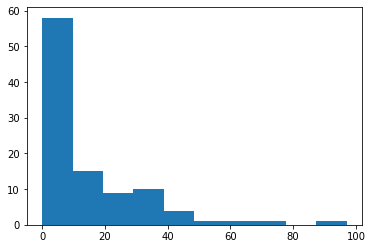

In [51]:
plt.hist(df_tr['ct_1'])